# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S7

## Panel a

In [2]:
# Correct indels in suppressor sequences

import ast
import pandas as pd

all_permissivity_seqs=pd.read_csv(path+'Fig6/Suppressor_library_allseqs.txt', sep='\t')

for index, row in all_permissivity_seqs.iterrows():
    if row.mutations.startswith('[')==True:
        mutations = ast.literal_eval(row.mutations)
        deletions=[]
        for mutation in mutations:
            if mutation[-1]=='-':
                deletions.append(mutation[1:-1])
        if len(deletions)>0:
            all_permissivity_seqs.at[index,'deletions']=','.join(deletions)
        full_variant=row.variant
        for deletion in deletions:
            full_variant = full_variant[:int(deletion)-1]+'-'+full_variant[int(deletion)-1:]
        all_permissivity_seqs.at[index,'full_variant']=full_variant
        all_permissivity_seqs.at[index,'full_variant_len']=len(full_variant)

In [3]:
import pandas as pd

permi_variants = pd.read_csv(path+'Fig6/FYN_suppressor_fitness_replicates.txt', sep='\t')


In [4]:
from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

permi_variants_scaled = permi_variants.copy()

arbitraryWT='FLFFVIV'

fig, ax = plt.subplots()

my_kde = kdeplot(data=permi_variants.loc[permi_variants['fitness']<-0.5], x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')

permi_variants_scaled['fitness']=normalize(list(permi_variants_scaled['fitness']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness1_uncorr']=normalize(list(permi_variants_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness1_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness2_uncorr']=normalize(list(permi_variants_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness2_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness3_uncorr']=normalize(list(permi_variants_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness3_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})


fig, ax = plt.subplots()

my_kde = kdeplot(data=permi_variants_scaled, x='fitness', ax=ax)

lines = my_kde.get_lines()

for line in lines:
    x, y = line.get_data()

plt.close()

In [5]:
WTs_bearing_natural_DTS_core_queries=pd.read_csv(path+'Fig6/Structural_homologs_carrying_detrimental_cores_in_FYN.txt',sep='\t')

for index, row in permi_variants_scaled.iterrows():
    if row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['DSSP_boundaries']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_1']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_2']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_3']):
        permi_variants_scaled.at[index,'other_natural_SH3s']=True
        if row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['DSSP_boundaries']):
            permi_variants_scaled.at[index,'Pro_mutant']=False
        else:
            permi_variants_scaled.at[index,'Pro_mutant']=True

other_natural_SH3s = permi_variants_scaled.loc[permi_variants_scaled['other_natural_SH3s']==True].copy()

In [6]:
# Find core and hamming distances

fyn_core_pos = [2,16,18,24,26,48,53]
fyn_wt_core = 'FLFFIIV'
fyn_permi_variants = permi_variants_scaled.loc[permi_variants_scaled['other_natural_SH3s']!=True].copy()
fyn_wt_seq = permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0].iloc[0]['aa_seq']
for index, row in fyn_permi_variants.iterrows():
    fyn_permi_variants.at[index,'full_variant']=all_permissivity_seqs.loc[all_permissivity_seqs['variant']==row.aa_seq].iloc[0]['full_variant']
    core=[]
    for i in fyn_core_pos:
        core.append(all_permissivity_seqs.loc[all_permissivity_seqs['variant']==row.aa_seq].iloc[0]['full_variant'][i])
    fyn_permi_variants.at[index,'core'] = ''.join(core)
    fyn_permi_variants.at[index, 'Nham_core'] = sum(1 for a,b in zip(core, fyn_wt_core) if a!=b)
    fyn_permi_variants.at[index, 'Nham_aa'] = sum(1 for a,b in zip(all_permissivity_seqs.loc[all_permissivity_seqs['variant']==row.aa_seq].iloc[0]['full_variant'], fyn_wt_seq) if a!=b)
    if len(row.aa_seq) != len(permi_variants.loc[permi_variants['Nham_aa']==0].iloc[0]['aa_seq']):
        fyn_permi_variants.at[index,'indel']=True
    fyn_permi_variants.at[index,'len']=len(row.aa_seq)

for index, row in fyn_permi_variants.iterrows():
    mutations=[]
    iterator=1
    for wt, mut in zip(fyn_wt_seq, row.full_variant):
        if wt != mut:
            mutations.append(wt+str(iterator)+mut)
        iterator+=1
    fyn_permi_variants.at[index,'all_mutations']=','.join(mutations)

In [7]:
# Discern query types

detrimental_singles_FYN = pd.read_csv(path+'Fig6/Suppressor_lib_singles_queries.txt', sep='\t', index_col=0)
query_natural_DTS_cores = pd.read_csv(path+'Fig6/Suppressor_lib_transplant_queries.txt', sep='\t', index_col=0)

for index, row in fyn_permi_variants.iterrows():
    if row.core in list(query_natural_DTS_cores.index):
        fyn_permi_variants.at[index,'query_type'] = 'Natural Core'
    else:
        fyn_permi_variants.at[index,'query_type'] = 'Single mutant'

In [8]:
# Find mutations and hamming distance to each core transplant query

natural_core_queries = fyn_permi_variants.loc[fyn_permi_variants['query_type']=='Natural Core'].copy()
fyn_wt_seq = fyn_permi_variants.loc[fyn_permi_variants['Nham_aa']==0].iloc[0]['aa_seq']
fyn_core_pos = [2,16,18,24,26,48,53]

for natural_query in list(query_natural_DTS_cores.index):
    query_seq=fyn_wt_seq
    for mut_res, pos in zip(natural_query,fyn_core_pos):
        query_seq = query_seq[:pos]+mut_res+query_seq[pos+1:]
    for index, row in natural_core_queries.iterrows():
        if row.core == natural_query:
            natural_core_queries.at[index,natural_query+'_total_Nham'] = sum(1 for a,b in zip(row.full_variant, query_seq) if a!=b)
            mutations=[]
            iterator=1
            for wt, mut in zip(query_seq, row.full_variant):
                if wt != mut:
                    mutations.append(wt+str(iterator)+mut)
                iterator+=1
            natural_core_queries.at[index,natural_query+'_mutations']=','.join(mutations)

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

iterator_cmap = 0

In [10]:
protein_variants_scaled = natural_core_queries.sort_values('fitness', ascending=False).copy()
for core in list(query_natural_DTS_cores.index):
    for index, row in protein_variants_scaled.loc[protein_variants_scaled['core']==core].iterrows():
        protein_variants_scaled.at[index, 'delta_fitness_from_mutant'] = row.fitness - natural_core_queries.loc[natural_core_queries['core']==core].loc[natural_core_queries[core+'_total_Nham']==0].iloc[0]['fitness']
        #protein_variants_scaled.at[index, 'rounded_fitness_in_mutant_bgd'] = round(row.fitness,1)
        try:
            protein_variants_scaled.at[index, 'delta_fitness_from_fyn'] = fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==row[core+'_mutations']].iloc[0]['fitness'] - fyn_permi_variants.loc[fyn_permi_variants['Nham_aa']==0].iloc[0]['fitness']
        except IndexError:
            continue

orig_cmap = plt.cm.coolwarm_r
norm = plt.Normalize(vmin=np.min(protein_variants_scaled['fitness']), vmax=np.max(protein_variants_scaled['fitness']))
iterator_cmap+=1
midpoint=(-0.5 - np.min(protein_variants_scaled['fitness']))/ (np.max(protein_variants_scaled['fitness']) - np.min(protein_variants_scaled['fitness']))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=midpoint, name='shifted'+str(iterator_cmap))

/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_8732/1441557314.py:53: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=newcmap)


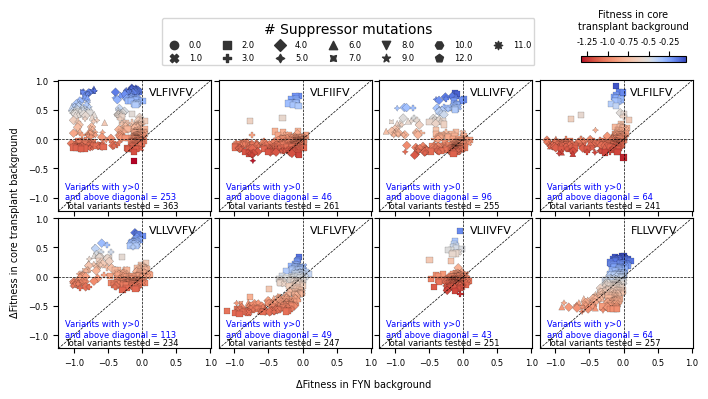

In [11]:
import seaborn as sns

symbols=['o','X','s','P','D',(4,1,0),'^',(4,1,45),'v','*','H',(8,1,0),'p']
markers={}
for mut_order, symbol in zip(np.arange(0,13,1).tolist(), symbols):
    markers[mut_order]=symbol

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(2.5*14/5,1.2*8/3), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.005, wspace=0.005)
coliterator=0
rowiterator=0
for core in list(query_natural_DTS_cores.index):
    ax[rowiterator,coliterator].axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)
    ax[rowiterator,coliterator].axvline(0,linestyle='dashed', color='black', lw=0.5)
    ax[rowiterator,coliterator].axhline(0,linestyle='dashed', color='black', lw=0.5)
    scat=sns.scatterplot(markers=markers,edgecolor='k',linewidth=0.1,s=20,ax=ax[rowiterator,coliterator],x='delta_fitness_from_fyn', y='delta_fitness_from_mutant',data=protein_variants_scaled.loc[protein_variants_scaled['core']==core], style = core+'_total_Nham', c = shifted_cmap(norm(protein_variants_scaled.loc[protein_variants_scaled['core']==core].loc[protein_variants_scaled['delta_fitness_from_fyn'].notnull()]['fitness'])), rasterized=True)
    ax[rowiterator,coliterator].set_ylim(np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.1,np.max(protein_variants_scaled['delta_fitness_from_mutant'])+0.1)
    ax[rowiterator,coliterator].set_xlim(np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.1,np.max(protein_variants_scaled['delta_fitness_from_mutant'])+0.1)
    ax[rowiterator,coliterator].tick_params(axis='x', labelsize=6)
    ax[rowiterator,coliterator].tick_params(axis='y', labelsize=6)
    ax[rowiterator,coliterator].get_legend().remove()
    ax[rowiterator,coliterator].set_xlabel('')
    ax[rowiterator,coliterator].set_ylabel('')
    ax[rowiterator,coliterator].annotate(core, (0.1,0.75), fontsize=8)
    ax[rowiterator,coliterator].annotate('Total variants tested = '+f"{len(protein_variants_scaled.loc[protein_variants_scaled['core']==core]):,}", (np.min(protein_variants_scaled['delta_fitness_from_fyn']),np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.05), fontsize=6)
    ax[rowiterator,coliterator].annotate('Variants with y>0\nand above diagonal = '+f"{len(protein_variants_scaled.loc[protein_variants_scaled['core']==core].loc[protein_variants_scaled['delta_fitness_from_fyn']<protein_variants_scaled['delta_fitness_from_mutant']].loc[protein_variants_scaled['delta_fitness_from_mutant']>0]):,}",  (np.min(protein_variants_scaled['delta_fitness_from_fyn']),np.min(protein_variants_scaled['delta_fitness_from_fyn'])+0.1), fontsize=6, color='blue')
    ax[rowiterator,coliterator].set_rasterization_zorder(0)
    coliterator+=1
    if coliterator >3:
        coliterator=0
        rowiterator+=1
handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
fig.legend(handle_list, label_list, ncols=7, title='# Suppressor mutations', bbox_to_anchor=[0.75,1.15], fontsize=6)
fig.text(0.5, -0.015, 'ΔFitness in FYN background', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'ΔFitness in core transplant background', va='center', rotation='vertical', fontsize=7)
#fig.delaxes(ax[-1,-1])
fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
cax=fig.add_axes([0.81,1,0.15,0.02])
cb=scat.figure.colorbar(plt.cm.ScalarMappable(cmap=shifted_cmap, norm=norm), cax=cax, location='top')
cax.set_xticks(np.arange(-1.25,0,0.25), np.arange(-1.25,0,0.25), fontsize=6)
cb.outline.set_visible(True)
cb.ax.set_title('Fitness in core\ntransplant background', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Permi_transplant_queries_delta_fitness_allmutants.svg', dpi=300, transparent=False, bbox_inches='tight')

## Panel b

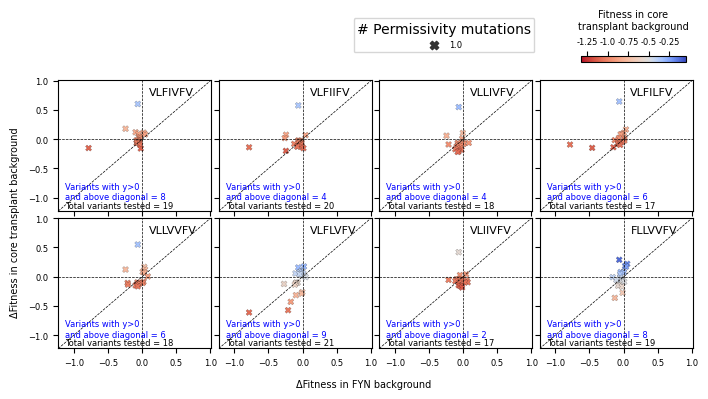

In [12]:
symbols=['o','X','s','P','D',(4,1,0),'^',(4,1,45),'v','*','H',(8,1,0),'p']
markers={}
for mut_order, symbol in zip(np.arange(0,13,1).tolist(), symbols):
    markers[mut_order]=symbol

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(2.5*14/5,1.2*8/3), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.005, wspace=0.005)
coliterator=0
rowiterator=0
for core in list(query_natural_DTS_cores.index):
    ax[rowiterator,coliterator].axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)
    ax[rowiterator,coliterator].axvline(0,linestyle='dashed', color='black', lw=0.5)
    ax[rowiterator,coliterator].axhline(0,linestyle='dashed', color='black', lw=0.5)
    scat=sns.scatterplot(markers=markers,edgecolor='k',linewidth=0.1,s=20,ax=ax[rowiterator,coliterator],x='delta_fitness_from_fyn', y='delta_fitness_from_mutant',data=protein_variants_scaled.loc[protein_variants_scaled['core']==core].loc[protein_variants_scaled[core+'_total_Nham']==1], style = core+'_total_Nham', c = shifted_cmap(norm(protein_variants_scaled.loc[protein_variants_scaled['core']==core].loc[protein_variants_scaled[core+'_total_Nham']==1].loc[protein_variants_scaled['delta_fitness_from_fyn'].notnull()]['fitness'])), rasterized=True)
    ax[rowiterator,coliterator].set_ylim(np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.1,np.max(protein_variants_scaled['delta_fitness_from_mutant'])+0.1)
    ax[rowiterator,coliterator].set_xlim(np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.1,np.max(protein_variants_scaled['delta_fitness_from_mutant'])+0.1)
    ax[rowiterator,coliterator].tick_params(axis='x', labelsize=6)
    ax[rowiterator,coliterator].tick_params(axis='y', labelsize=6)
    ax[rowiterator,coliterator].get_legend().remove()
    ax[rowiterator,coliterator].set_xlabel('')
    ax[rowiterator,coliterator].set_ylabel('')
    ax[rowiterator,coliterator].annotate(core, (0.1,0.75), fontsize=8)
    ax[rowiterator,coliterator].annotate('Total variants tested = '+f"{len(protein_variants_scaled.loc[protein_variants_scaled['core']==core].loc[protein_variants_scaled[core+'_total_Nham']==1]):,}", (np.min(protein_variants_scaled['delta_fitness_from_fyn']),np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.05), fontsize=6)
    ax[rowiterator,coliterator].annotate('Variants with y>0\nand above diagonal = '+f"{len(protein_variants_scaled.loc[protein_variants_scaled['core']==core].loc[protein_variants_scaled['delta_fitness_from_fyn']<protein_variants_scaled['delta_fitness_from_mutant']].loc[protein_variants_scaled['delta_fitness_from_mutant']>0].loc[protein_variants_scaled[core+'_total_Nham']==1]):,}",  (np.min(protein_variants_scaled['delta_fitness_from_fyn']),np.min(protein_variants_scaled['delta_fitness_from_fyn'])+0.1), fontsize=6, color='blue')
    ax[rowiterator,coliterator].set_rasterization_zorder(0)
    coliterator+=1
    if coliterator >3:
        coliterator=0
        rowiterator+=1
handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
fig.legend(handle_list, label_list, ncols=7, title='# Permissivity mutations', bbox_to_anchor=[0.75,1.15], fontsize=6)
fig.text(0.5, -0.015, 'ΔFitness in FYN background', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'ΔFitness in core transplant background', va='center', rotation='vertical', fontsize=7)
#fig.delaxes(ax[-1,-1])
fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
cax=fig.add_axes([0.81,1,0.15,0.02])
cb=scat.figure.colorbar(plt.cm.ScalarMappable(cmap=shifted_cmap, norm=norm), cax=cax, location='top')
cax.set_xticks(np.arange(-1.25,0,0.25), np.arange(-1.25,0,0.25), fontsize=6)
cb.outline.set_visible(True)
cb.ax.set_title('Fitness in core\ntransplant background', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Permi_transplant_queries_delta_fitness_singlesonlymutants.svg', dpi=300, transparent=False, bbox_inches='tight')